In [144]:
# @title datamodel
import json
from typing import Dict, List
from json import JSONEncoder
#import jsonpickle

Time = int
Symbol = str
Product = str
Position = int
UserId = str
ObservationValue = int


class Listing:

    def __init__(self, symbol: Symbol, product: Product, denomination: Product):
        self.symbol = symbol
        self.product = product
        self.denomination = denomination


class ConversionObservation:

    def __init__(self, bidPrice: float, askPrice: float, transportFees: float, exportTariff: float, importTariff: float, sunlight: float, humidity: float):
        self.bidPrice = bidPrice
        self.askPrice = askPrice
        self.transportFees = transportFees
        self.exportTariff = exportTariff
        self.importTariff = importTariff
        self.sunlight = sunlight
        self.humidity = humidity


class Observation:

    def __init__(self, plainValueObservations: Dict[Product, ObservationValue], conversionObservations: Dict[Product, ConversionObservation]) -> None:
        self.plainValueObservations = plainValueObservations
        self.conversionObservations = conversionObservations

    def __str__(self) -> str:
        return "(plainValueObservations: " + jsonpickle.encode(self.plainValueObservations) + ", conversionObservations: " + jsonpickle.encode(self.conversionObservations) + ")"


class Order:

    def __init__(self, symbol: Symbol, price: int, quantity: int) -> None:
        self.symbol = symbol
        self.price = price
        self.quantity = quantity

    def __str__(self) -> str:
        return "(" + self.symbol + ", " + str(self.price) + ", " + str(self.quantity) + ")"

    def __repr__(self) -> str:
        return "(" + self.symbol + ", " + str(self.price) + ", " + str(self.quantity) + ")"


class OrderDepth:

    def __init__(self, buy_orders=None, sell_orders=None):
        self.buy_orders = buy_orders if buy_orders is not None else {}
        self.sell_orders = sell_orders if sell_orders is not None else {}

class Trade:

    def __init__(self, symbol: Symbol, price: int, quantity: int, buyer: UserId=None, seller: UserId=None, timestamp: int=0) -> None:
        self.symbol = symbol
        self.price: int = price
        self.quantity: int = quantity
        self.buyer = buyer
        self.seller = seller
        self.timestamp = timestamp

    def __str__(self) -> str:
        return "(" + self.symbol + ", " + self.buyer + " << " + self.seller + ", " + str(self.price) + ", " + str(self.quantity) + ", " + str(self.timestamp) + ")"

    def __repr__(self) -> str:
        return "(" + self.symbol + ", " + self.buyer + " << " + self.seller + ", " + str(self.price) + ", " + str(self.quantity) + ", " + str(self.timestamp) + ")"


class TradingState(object):

    def __init__(self,
                 traderData: str,
                 timestamp: Time,
                 listings: Dict[Symbol, Listing],
                 order_depths: Dict[Symbol, OrderDepth],
                 own_trades: Dict[Symbol, List[Trade]],
                 market_trades: Dict[Symbol, List[Trade]],
                 position: Dict[Product, Position],
                 observations: Observation):
        self.traderData = traderData
        self.timestamp = timestamp
        self.listings = listings
        self.order_depths = order_depths
        self.own_trades = own_trades
        self.market_trades = market_trades
        self.position = position
        self.observations = observations

    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True)


class ProsperityEncoder(JSONEncoder):

        def default(self, o):
            return o.__dict__

In [145]:
import pandas as pd
import numpy as np

import math
import statistics
from typing import List

In [146]:
import matplotlib.pyplot as plt
import random


In [147]:
def generate_order_depths(timestamp=0, max_b=135, min_b=100, max_s=140, min_s=105, coef=0.0625, Q=10, Seed=np.random.seed(42)):
    # Define listings with two additional products
    listings = {
        "PRODUCT1": Listing("PRODUCT1", "PRODUCT1", "SEASHELLS"),
    }

    random.seed(Seed)

    # Function to generate detailed order depths
    def generate_order_depths(max_b=135, min_b=100, max_s=140, min_s=105, coef=0.0625, Q=10):
        buy_prices = range(min_b, max_b)
        sell_prices = range(min_s, max_s)

        excess_quantity = int(np.random.normal(loc=0, scale=Q/4))

        Q_buy = max(min(Q, int(np.random.normal(loc=Q/2, scale=Q/8))), 0) + excess_quantity
        Q_sell = Q + excess_quantity - Q_buy

        pdf_b = np.exp(-(np.array(buy_prices) - (max_b + min_b) / 2) ** 2 / (coef * (max_b - min_b) ** 2))
        pdf_bn = pdf_b / np.sum(pdf_b)
        pdf_s = np.exp(-(np.array(sell_prices) - (max_s + min_s) / 2) ** 2 / (coef * (max_s - min_s) ** 2))
        pdf_sn = pdf_s / np.sum(pdf_s)

        # Generate quantities based on the defined distribution
        buy_quantities = np.round(np.random.choice(buy_prices, size=Q, replace=True, p=pdf_bn)).astype(int)
        sell_quantities = np.round(np.random.choice(sell_prices, size=Q, replace=True, p=pdf_sn)).astype(int)

        # Aggregate quantities for each price
        buy_orders = {price: np.sum(buy_quantities == price) for price in buy_prices}
        sell_orders = {price: -np.sum(sell_quantities == price) for price in sell_prices}

        return OrderDepth(buy_orders, sell_orders)

    # Define detailed order depths for each product
    order_depths = {
        product: generate_order_depths() for product in listings
    }

    # Initialize own trades and market trades with empty lists for all products
    own_trades = {product: [] for product in listings}
    market_trades = {product: [] for product in listings}

    # Define positions for each product with random values
    position = {
        product: random.randint(-10, 10) for product in listings
    }

    # Assuming observations and traderData initialization
    observations = {}
    traderData = ""

    # Create the TradingState instance with expanded data
    state = TradingState(
        traderData,
        timestamp,
        listings,
        order_depths,
        own_trades,
        market_trades,
        position,
        observations
    )

    return state


In [186]:
timestamp = 100

listings = {
	"AMETHYSTS": Listing(
		symbol="AMETHYSTS", 
		product="AMETHYSTS", 
		denomination= "SEASHELLS"
	),
	"PRODUCT2": Listing(
		symbol="PRODUCT2", 
		product="PRODUCT2", 
		denomination= "SEASHELLS"
	),
}

order_depths = {
	"AMETHYSTS": OrderDepth(
		buy_orders={10000: 7, 9998: 5},
		sell_orders={10000: -5, 10002: -3}
	),
	"PRODUCT2": OrderDepth(
		buy_orders={142: 3, 141: 5},
		sell_orders={144: -5, 145: -8}
	),	
}

own_trades = {
	"AMETHYSTS": [
		Trade(
			symbol="AMETHYSTS",
			price=9998,
			quantity=4,
			buyer="SUBMISSION",
			seller="",
			timestamp=1000
		),
		Trade(
			symbol="AMETHYSTS",
			price=10000,
			quantity=3,
			buyer="SUBMISSION",
			seller="",
			timestamp=1000
		)
	],
	"PRODUCT2": [
		Trade(
			symbol="PRODUCT2",
			price=143,
			quantity=2,
			buyer="",
			seller="SUBMISSION",
			timestamp=1000
		),
	]
}

market_trades = {
	"AMETHYSTS": [],
	"PRODUCT2": []
}

position = {
	"AMETHYSTS": 10,
	"PRODUCT2": -7
}

observations = {}

traderData = "SAMPLE"

state = TradingState(
	traderData,
	timestamp,
  listings,
	order_depths,
	own_trades,
	market_trades,
	position,
	observations
)

In [171]:
class Trader_basic:
    
    def run(self, state: TradingState):
        print("traderData: " + state.traderData)
        print("Observations: " + str(state.observations))

				# Orders to be placed on exchange matching engine
        result = {}
        for product in state.order_depths:
            order_depth: OrderDepth = state.order_depths[product]
            orders: List[Order] = []
            acceptable_price = 10  # Participant should calculate this value
            print("Acceptable price : " + str(acceptable_price))
            print("Buy Order depth : " + str(len(order_depth.buy_orders)) + ", Sell order depth : " + str(len(order_depth.sell_orders)))
    
            if len(order_depth.sell_orders) != 0:
                best_ask, best_ask_amount = list(order_depth.sell_orders.items())[0]
                print(f'Best Ask: {best_ask_amount}')
                if int(best_ask) < acceptable_price:
                    print("BUY", str(-best_ask_amount) + "x", best_ask)
                    orders.append(Order(product, best_ask, -best_ask_amount))
    
            if len(order_depth.buy_orders) != 0:
                best_bid, best_bid_amount = list(order_depth.buy_orders.items())[0]
                print(f'Best bid: {best_bid_amount}')
                if int(best_bid) > acceptable_price:
                    print("SELL", str(best_bid_amount) + "x", best_bid)
                    orders.append(Order(product, best_bid, -best_bid_amount))
            
            result[product] = orders
    
		    # String value holding Trader state data required. 
				# It will be delivered as TradingState.traderData on next execution.
        traderData = "SAMPLE" 
        
				# Sample conversion request. Check more details below. 
        conversions = 1
        return result, conversions, traderData

In [216]:
class Trader:
    
      def run(self, state: TradingState):
            state.traderData = 'AMETHYSTS:0,0,0,0,10000:0.PRODUCT2:0,0,0,0,10000:0.'
            print("traderData: " + state.traderData)
            print("Observations: " + str(state.observations))
            n = 5
            scale = 100


            def calculate_midprice(product, buy_orders, sell_orders, price_basic=10000):
                  Set_p_q = []
                  try:
                        for p in buy_orders:
                              Set_p_q.append([p, buy_orders[p]])
                  except:
                        Set_p_q.append([price_basic,1])

                  try:
                        for p in sell_orders:
                              Set_p_q.append([p, sell_orders[p]])
                  except:
                        Set_p_q.append([price_basic,1])

                  Set_p_q = np.array(Set_p_q)
                  Q = np.abs(Set_p_q[:,1]).sum()
                  midprice = (Set_p_q[:,0] * abs(Set_p_q[:,1]) / Q).sum()

                  return midprice
                  
            def get_traderData(state, product):
                  parts = state.traderData.split('.')
                  for i, part in enumerate(parts):
                        Prod = part.split(':')[0]
                        if Prod == product:
                              index_of_product = i
                  try:
                        dummy_computation = (index_of_product) + 1
                  except:
                        index_of_product = None

                  print(index_of_product)
                  if index_of_product != None:
                        trader_data_product = parts[index_of_product]
                        splited_trader_data_product = trader_data_product.split(':')
                        inventory = prices = float(splited_trader_data_product[2])
                        Prices = np.array(splited_trader_data_product[1].split(',')).astype(float)
                        new_Prices = Prices[1:]

                        return Prices, new_Prices, inventory

            trader_data = ""

            result = {}
            for product in state.order_depths:
                  if state.timestamp < n*scale:
                        order_depth: OrderDepth = state.order_depths[product]
                        orders: List[Order] = []

                        midprice = calculate_midprice(product, buy_orders=state.order_depths[product].buy_orders, 
                                                      sell_orders=state.order_depths[product].sell_orders)
                        
                        if state.timestamp == 0:
                              prices_str = ""
                              for _ in range(n-1):
                                    prices_str += f'{0},'
                              prices_str += f'{midprice}'
                              inventory = 0

                              trader_data_product = f'{product}:{prices_str}:{inventory}.'
                        else:
                              Prices, new_Prices, inventory = get_traderData(state, product)
                              prices_str = ''
                              for price in new_Prices:
                                    prices_str += f'{price}'
                              trader_data_product = f'{product}:{prices_str}:{inventory}.'
                        
                        trader_data += trader_data_product

                  else:
                        
                        order_depth: OrderDepth = state.order_depths[product]
                        orders: List[Order] = []

                        Prices, new_Prices, inventory = get_traderData(state, product)
                        if np.abs(Prices - 10000).mean() > 2:
                              market = 1
                        else:
                              market = 0

                        acceptable_price = 10000  # Participant should calculate this value
                        print("Acceptable price : " + str(acceptable_price))
                        print("Buy Order depth : " + str(len(order_depth.buy_orders)) + ", Sell order depth : " + str(len(order_depth.sell_orders)))


                        if len(order_depth.sell_orders) != 0:
                              best_ask, best_ask_amount = list(order_depth.sell_orders.items())[0]
                              if int(best_ask) < acceptable_price:
                                    print("BUY", str(-best_ask_amount) + "x", best_ask)
                                    orders.append(Order(product, best_ask, -best_ask_amount))
            
                        if len(order_depth.buy_orders) != 0:
                              best_bid, best_bid_amount = list(order_depth.buy_orders.items())[0]
                              if int(best_bid) > acceptable_price:
                                    print("SELL", str(best_bid_amount) + "x", best_bid)
                                    orders.append(Order(product, best_bid, -best_bid_amount))
                        
                        result[product] = orders
            
                  # String value holding Trader state data required. 
                              # It will be delivered as TradingState.traderData on next execution.
            traderData = trader_data 
            
                              # Sample conversion request. Check more details below. 
            conversions = 1
            return result, conversions, traderData

In [223]:
pd.Series(np.array([0,4,3,6,5])).diff().dropna().mean()

1.25

In [217]:
result, conversions, traderData = Trader().run(state=state)

traderData: AMETHYSTS:0,0,0,0,10000:0.PRODUCT2:0,0,0,0,10000:0.
Observations: {}
0
1


In [206]:
traderData = 'AMETHYSTS:0,0,0,0,10000:0.PRODUCT2:0,0,0,0,10000.0:0.'

In [207]:
trader_data_product

'AMETHYSTS:0,0,0,0,10000'

array([    0.,     0.,     0.,     0., 10000.])

In [208]:
trader_data_product = traderData.split('.')[0]

splited_trader_data_product = trader_data_product.split(':')
prices = splited_trader_data_product[1]
inventory = float(splited_trader_data_product[2])
Prices = []
for price in prices.split(','):
                              Prices.append(float(price))
                                    
Prices.append(10)
Prices = np.array(Prices)
new_Prices = Prices[1:]


In [139]:
traderdata = 'PRODUCT1:2,3,4:5:'


In [141]:
(traderdata.split(':'))


['PRODUCT1', '2,3,4', '5', '']

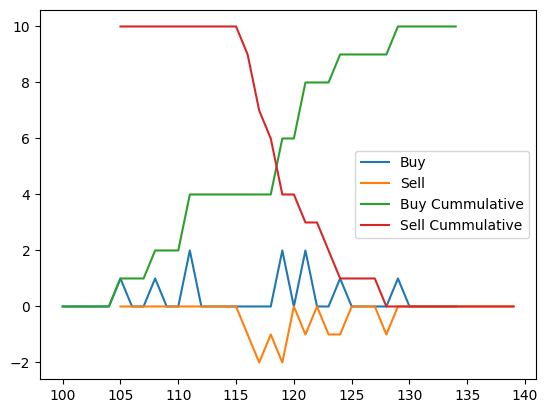

In [ ]:
# Separating prices and quantities
prices_b = np.array(list(state.order_depths['PRODUCT1'].buy_orders.keys()))
quantities_b = np.array(list(state.order_depths['PRODUCT1'].buy_orders.values()))

prices_s = np.array(list(state.order_depths['PRODUCT1'].sell_orders.keys()))
quantities_s = np.array(list(state.order_depths['PRODUCT1'].sell_orders.values()))

plt.plot((prices_b), quantities_b, label='Buy')
plt.plot((prices_s), quantities_s, label='Sell')

plt.plot((prices_b), quantities_b.cumsum(), label='Buy Cummulative')
plt.plot((prices_s), (quantities_s).cumsum() + sum(abs(quantities_s)), label='Sell Cummulative')


plt.legend()
plt.show()

in the trader class, make it empty and i will now give you instructions for a function (call it trade_oscilation_for_trend) that makes trades.

Make the following variables in this the state, the product, if you are buying or selling, which index of the list(order_depth.sell_orders.items())[index] or list(order_depth.buy_orders.items())[index] you want (keep in mind that i can only buy from the sell orders and sell to the buy orders), the trend_price, last_price, large_diff_up, small_diff_up, large_diff_down, small_diff_down, market_up, market_down, max_trade_volume.

So now the logic i want is:
when I'm buying (looking at the sell_orders) for some specific index, if the price is better than the ask_price <= trend_price - large_diff_down
Then buy

if the ask_price <= trend_price - small_diff_down, then:
(if the ask_price is smaller than the previous_price by more than small_diff_down and market_d=0, then buy it at that price
else, if the |ask_price-previous_price| < min(small_diff_down, small_diff_up) and market_d=0, then also buy it at that price.
)

Now if the ask_price is between the trend_price and the trend_price+ small_diff_up, and also ask price is bigger than the previous_price and market_u = 1
also buy.

When you buy,  buyas many orders as you can with a maximum of max_trade_volume and also return ['Buy', state.timestamp, ask, ask_amount], (don't check the other statements)

array([4, 3])

In [ ]:
class Trader:
      def __init__(self):
            self.prices = [[],[]]
            self.Orders = [[],[]]
      
      def trade_oscillation_for_trend(self, state, product, action, index, trend_price, last_price, large_diff_up, small_diff_up, large_diff_down, small_diff_down, market_up, market_down, max_trade_volume):
            Orders = []
            order_depth = state.order_depths[product]
            if action == 'buy':
                  sell_orders = list(order_depth.sell_orders.items())
                  if index < len(sell_orders):
                        ask_price, ask_amount = sell_orders[index]
                        ask_amount = abs(ask_amount)
                        # Buying logic based on the trend_price and price differences
                        if ask_price <= trend_price - large_diff_down:
                              # Buy logic when price is significantly lower than trend
                              buy_amount = min(ask_amount, max_trade_volume)
                              return 'Buy', state.timestamp, ask_price, buy_amount
                        elif ask_price <= trend_price - small_diff_down:
                              if ask_price < last_price - small_diff_down and market_down == 0:
                                    # Buy if the price drop is significant and market is not trending down
                                    buy_amount = min(ask_amount, max_trade_volume)
                                    return 'Buy', state.timestamp, ask_price, buy_amount
                              elif abs(ask_price - last_price) < min(small_diff_down, small_diff_up) and market_down == 0:
                                    # Buy if the price difference is small and market is stable
                                    buy_amount = min(ask_amount, max_trade_volume)
                                    return 'Buy', state.timestamp, ask_price, buy_amount
                        elif trend_price < ask_price <= trend_price + small_diff_up and ask_price > last_price and market_up == 1:
                              # Buy if the price is slightly up within a threshold and market is trending up
                              buy_amount = min(ask_amount, max_trade_volume)
                              return 'Buy', state.timestamp, ask_price, buy_amount
                  return None, state.timestamp, ask_price, ask_amount
            
            # Further selling logic can be implemented similarly based on requirements
            elif action == 'sell':
                  buy_orders = list(order_depth.buy_orders.items())
                  if index < len(buy_orders):
                        bid_price, bid_amount = buy_orders[index]
                        bid_amount = abs(bid_amount)
                        # Selling logic based on the trend_price and price differences
                        if bid_price >= trend_price + large_diff_up:
                              # Sell logic when price is significantly higher than trend
                              sell_amount = min(bid_amount, max_trade_volume)
                              return 'Buy', state.timestamp, ask_price, buy_amount
                        elif bid_price >= trend_price + small_diff_up:
                              if bid_price > last_price + small_diff_up and market_up == 0:
                                    # Sell if the price rise is significant and market is not trending up
                                    sell_amount = min(bid_amount, max_trade_volume)
                                    return 'Buy', state.timestamp, ask_price, buy_amount
                              elif abs(bid_price - last_price) < min(small_diff_up, small_diff_down) and market_up == 0:
                                    # Sell if the price difference is small and market is stable
                                    sell_amount = min(bid_amount, max_trade_volume)
                                    return 'Buy', state.timestamp, ask_price, buy_amount
                        elif trend_price - small_diff_down < bid_price <= trend_price and bid_price < last_price and market_down == 1:
                              # Sell if the price is slightly down within a threshold and market is trending down
                              sell_amount = min(bid_amount, max_trade_volume)
                              return 'Buy', state.timestamp, ask_price, buy_amount
                  return None, state.timestamp, ask_price, buy_amount
                                    
      def run(self, state: TradingState):
            print("traderData: " + state.traderData)
            print("Observations: " + str(state.observations))

				    # Orders to be placed on exchange matching engine
            result = {}
            for product in state.order_depths:
                  if state.timestamp < 10 * 100:
                        if product == 'AMETHYSTS':
                              trend_price_A = 10000
                              large_diff_upA, small_diff_upA, large_diff_downA, small_diff_downA = 4, 2, 4, 2
                              Set_p_q = []
                              for p in state.order_depths[product].buy_orders:
                                    Set_p_q.append([p, state.order_depths[product].buy_orders[p]])
                              for p in state.order_depths[product].sell_orders:
                                    Set_p_q.append([p, state.order_depths[product].sell_orders[p]])
                              Set_p_q = np.array(Set_p_q)
                              Q = np.abs(Set_p_q[:,1]).sum()
                              midprice = (Set_p_q[:,0] * abs(Set_p_q[:,1]) / Q).sum()
                              self.prices[0].append(midprice)

                              order_depth: OrderDepth = state.order_depths[product]
                              orders: List[Order] = []
                  else:
                        if product == 'AMETHYSTS':
                              trend_price_A = 10000
                              large_diff_upA, small_diff_upA, large_diff_downA, small_diff_downA = 4, 2, 4, 2
                              range_care = 5
                              Set_p_q = []
                              for p in state.order_depths[product].buy_orders:
                                    Set_p_q.append([p, state.order_depths[product].buy_orders[p]])
                              for p in state.order_depths[product].sell_orders:
                                    Set_p_q.append([p, state.order_depths[product].sell_orders[p]])
                              Set_p_q = np.array(Set_p_q)
                              Q = np.abs(Set_p_q[:,1]).sum()
                              midprice = (Set_p_q[:,0] * abs(Set_p_q[:,1]) / Q).sum()
                              self.prices[0].append(midprice)
                              Prices = np.array(prices[0])
                              Prices_u = Prices[Prices > trend_price_A] - trend_price_A
                              Prices_d = trend_price_A - Prices[Prices < trend_price_A]
                              if Prices_u[-range_care:].mean() > small_diff_upA:
                                    market_u_A = 1
                              else:
                                    market_u_A = 0
                              if Prices_d[-range_care:].mean() > small_diff_downA:
                                    market_d_A = 1
                              else:
                                    market_d_A = 0
                              
                              if len(self.Orders) == 0:
                                    max_trade_volume_A = 20
                                    inventory = 0
                              else:
                                    np_ordersA = np.array(self.Orders[0])
                                    inventory = np_ordersA[:,3].astype(float).sum()

                              if inventory == 0:
                                    if midprice > trend_price_A:
                                          try:
                                                action, time, price, amount = self.trade_oscillation_for_trend(state, product=product, action='Sell', index=0, trend_price=trend_price_A, last_price=Prices[-2], 
                                                                                                            large_diff_up=large_diff_upA, small_diff_up=small_diff_upA, 
                                                                                                            large_diff_down=large_diff_downA, small_diff_down=small_diff_downA,
                                                                                                            market_up=market_u_A, market_down=market_d_A, max_trade_volume=max_trade_volume_A)
                                          except:
                                                action, time, price, amount = self.trade_oscillation_for_trend(state, product=product, action='Buy', index=0, trend_price=trend_price_A, last_price=Prices[-2], 
                                                                                                            large_diff_up=large_diff_upA, small_diff_up=small_diff_upA, 
                                                                                                            large_diff_down=large_diff_downA, small_diff_down=small_diff_downA,
                                                                                                            market_up=market_u_A, market_down=market_d_A, max_trade_volume=max_trade_volume_A)
                                          try:      
                                                if action == None:
                                                      action, time, price, amount = self.trade_oscillation_for_trend(state, product=product, action='Buy', index=0, trend_price=trend_price_A, last_price=Prices[-2], 
                                                                                                                  large_diff_up=large_diff_upA, small_diff_up=small_diff_upA, 
                                                                                                                  large_diff_down=large_diff_downA, small_diff_down=small_diff_downA,
                                                                                                                  market_up=market_u_A, market_down=market_d_A, max_trade_volume=max_trade_volume_A)
                                          except:
                                                continue
                                          if action == None:
                                                break
                                          else:
                                                if action == 'Sell': #To Bid
                                                      orders.append(Order(product, price, -abs(amount)))
                                                      self.Orders[0].append(action, time, price, -abs(amount))
                                                elif action == 'Buy': #From Ask
                                                      orders.append(Order(product, price, abs(amount)))
                                                      self.Orders[0].append(action, time, price, abs(amount))
                                                

                                                np_ordersA = np.array(self.Orders[0])
                                                inventory = np_ordersA[:,3].astype(float).sum()
                                                
                                                if abs(inventory) < 20 and action == 'Buy':
                                                      try:
                                                            action, time, price, amount = self.trade_oscillation_for_trend(state, product=product, action='Buy', index=1, trend_price=trend_price_A, last_price=Prices[-2], 
                                                                                                                        large_diff_up=large_diff_upA, small_diff_up=small_diff_upA, 
                                                                                                                        large_diff_down=large_diff_downA, small_diff_down=small_diff_downA,
                                                                                                                        market_up=market_u_A, market_down=market_d_A, max_trade_volume=max_trade_volume_A)
                                                      except:
                                                            continue                                                     
                                                      np_ordersA = np.array(self.Orders[0])
                                                      inventory = np_ordersA[:,3].astype(float).sum()

                                                      if action == None:
                                                            continue

                                                      else:
                                                            if action == 'Sell': #To Bid
                                                                  orders.append(Order(product, price, -abs(amount)))
                                                                  self.Orders[0].append(action, time, price, -abs(amount))
                                                            elif action == 'Buy': #From Ask
                                                                  orders.append(Order(product, price, abs(amount)))
                                                                  self.Orders[0].append(action, time, price, abs(amount))
                                                            np_ordersA = np.array(self.Orders[0])
                                                            inventory = np_ordersA[:,3].astype(float).sum()
                                                            try:
                                                                  action, time, price, amount = self.trade_oscillation_for_trend(state, product=product, action='Buy', index=1, trend_price=trend_price_A, last_price=Prices[-2], 
                                                                                                                              large_diff_up=large_diff_upA, small_diff_up=small_diff_upA, 
                                                                                                                              large_diff_down=large_diff_downA, small_diff_down=small_diff_downA,
                                                                                                                              market_up=market_u_A, market_down=market_d_A, max_trade_volume=max_trade_volume_A)
                                                            except:
                                                                  continue
                              elif inventory > 0:
                                    # We need to Sell to Bid (oreder amount is negative)
                                    if len(order_depth.buy_orders) != 0:
                                          price_0, amount_0 = list(order_depth.sell_orders.items())[0]
                                          if amount_0 > inventory:
                                                orders.append(Order(product, price_0, -abs(inventory)))
                                          else:
                                                orders.append(Order(product, price_0, -abs(amount_0)))
                                                price_1, amount_1 = list(order_depth.sell_orders.items())[1]
                                                self.Orders[0].append('Sell', state.timestamp, price_0, -abs(amount_0))
                                                np_ordersA = np.array(self.Orders[0])
                                                inventory = np_ordersA[:,3].astype(float).sum()
                                                if amount_1 > inventory:
                                                      orders.append(Order(product, price, -abs(inventory)))
                                                else:
                                                      orders.append(Order(product, price_0, -abs(amount_1)))
                                                      price_2, amount_2 = list(order_depth.sell_orders.items())[2]
                                                      self.Orders[0].append('Sell', state.timestamp, price_0, -abs(amount_1))
                                                      np_ordersA = np.array(self.Orders[0])
                                                      inventory = np_ordersA[:,3].astype(float).sum()


                              if inventory < 0:
                                    # Ensure there are sell orders to buy from
                                    if len(order_depth.sell_orders) != 0:
                                          # Get the first sell order to buy from
                                          price_0, amount_0 = list(order_depth.sell_orders.items())[0]
                                          # Adjusting inventory by buying, check if we can cover all inventory with the first order
                                          if abs(amount_0) >= abs(inventory):
                                                orders.append(Order(product, price_0, abs(inventory)))
                                                self.Orders[0].append('Buy', state.timestamp, price_0, abs(inventory))
                                                inventory += abs(inventory)  # Update inventory to reflect the buy
                                          else:
                                                # If the first order is not enough to cover inventory, buy the entire first order amount
                                                orders.append(Order(product, price_0, abs(amount_0)))
                                                self.Orders[0].append('Buy', state.timestamp, price_0, abs(amount_0))
                                                inventory += abs(amount_0)  # Update inventory
                                                
                                                # Attempt to cover the remaining inventory with subsequent orders
                                                for i in range(1, len(order_depth.sell_orders)):
                                                      price_i, amount_i = list(order_depth.sell_orders.items())[i]
                                                      if abs(amount_i) >= abs(inventory):
                                                            orders.append(Order(product, price_i, abs(inventory)))
                                                            self.Orders[0].append('Buy', state.timestamp, price_i, abs(inventory))
                                                            inventory = 0  # Inventory fully covered
                                                            break  # Exit the loop as the short position has been covered
                                                      else:
                                                            orders.append(Order(product, price_i, abs(amount_i)))
                                                            self.Orders[0].append('Buy', state.timestamp, price_i, abs(amount_i))
                                                            inventory += abs(amount_i)  # Update inventory
                        


                              order_depth: OrderDepth = state.order_depths[product]
                              orders: List[Order] = []

                  result[product] = orders
      
            # String value holding Trader state data required. 
            # It will be delivered as TradingState.traderData on next execution.
            traderData = "SAMPLE" 
        
				    # Sample conversion request. Check more details below. 
            conversions = 1
            return result, conversions, traderData

In [69]:
Orders = [[['Buy', 100, 5, 4], ['Sell', 100, 6, -3]],[['Buy', 100, 5, 4], ['Sell', 100, 6, -3]]]

In [76]:
np.array(Orders[0])[:,2].astype(float).astype(float)

array([5., 6.])

In [70]:
Orders

[[['Buy', 100, 5, 4], ['Sell', 100, 6, -3]],
 [['Buy', 100, 5, 4], ['Sell', 100, 6, -3]]]

In [4]:
import os

# Get the directory of the current script
script_directory = os.path.dirname(os.path.abspath('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/IMC_Prosperity_test.ipynb'))

# Change the current working directory
os.chdir(script_directory)

print("Current Working Directory is changed to:", os.getcwd())

prices_day0 = pd.read_csv('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 1/round-1-island-data-bottle/prices_round_1_day_0.csv', sep=";")
prices_day1 = pd.read_csv('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 1/round-1-island-data-bottle/prices_round_1_day_-1.csv', sep=";")
prices_day2 = pd.read_csv('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 1/round-1-island-data-bottle/prices_round_1_day_-2.csv', sep=";")

trades_day0 = pd.read_csv('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 1/round-1-island-data-bottle/trades_round_1_day_0_nn.csv', sep=";")
trades_day1 = pd.read_csv('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 1/round-1-island-data-bottle/trades_round_1_day_-1_nn.csv', sep=";")
trades_day2 = pd.read_csv('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 1/round-1-island-data-bottle/trades_round_1_day_-2_nn.csv', sep=";")

Current Working Directory is changed to: /Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies


In [5]:
prices_day2

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,0.0
2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,20,NaN,NaN,NaN,NaN,5002.0,0.0
4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-2,999700,AMETHYSTS,9995,22,NaN,NaN,NaN,NaN,10005,22,NaN,NaN,NaN,NaN,10000.0,0.0
19996,-2,999800,STARFRUIT,5041,1,5040.0,25.0,NaN,NaN,5045,3,5047.0,26.0,NaN,NaN,5043.0,0.0
19997,-2,999800,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,9998,1,10002.0,9.0,10004.0,1.0,9997.0,0.0
19998,-2,999900,STARFRUIT,5044,4,5040.0,32.0,NaN,NaN,5047,32,NaN,NaN,NaN,NaN,5045.5,0.0


In [46]:
trades_day0_S = trades_day0[trades_day0.symbol == 'STARFRUIT']
trades_day0_A = trades_day0[trades_day0.symbol == 'AMETHYSTS']
trades_day1_S = trades_day1[trades_day1.symbol == 'STARFRUIT']
trades_day1_A = trades_day1[trades_day1.symbol == 'AMETHYSTS']
trades_day2_S = trades_day2[trades_day2.symbol == 'STARFRUIT']
trades_day2_A = trades_day2[trades_day2.symbol == 'AMETHYSTS']


<Axes: >

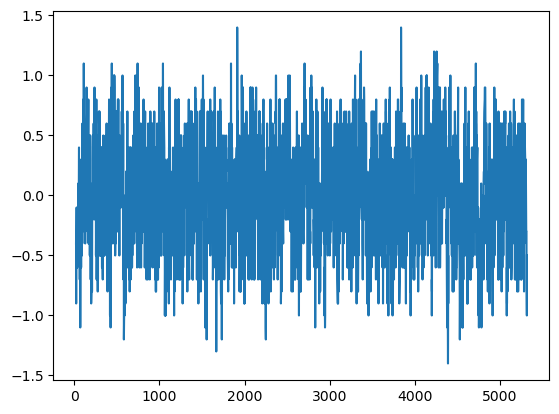

In [224]:
trades_day0_S.price.diff().rolling(10).mean().plot()

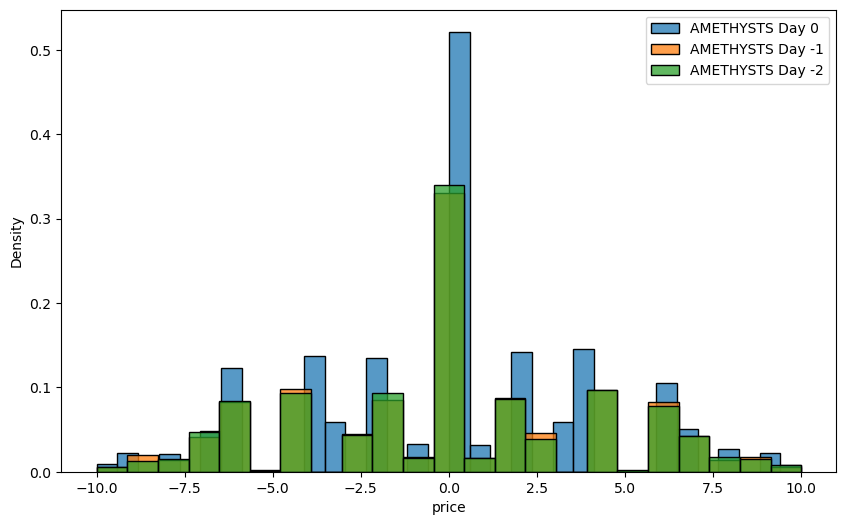

In [47]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(trades_day0_A.price.diff(), stat='density', label='AMETHYSTS Day 0')
sns.histplot(trades_day1_A.price.diff(), stat='density', label='AMETHYSTS Day -1')
sns.histplot(trades_day2_A.price.diff(), stat='density', label='AMETHYSTS Day -2')

plt.legend()
plt.show()

<Axes: >

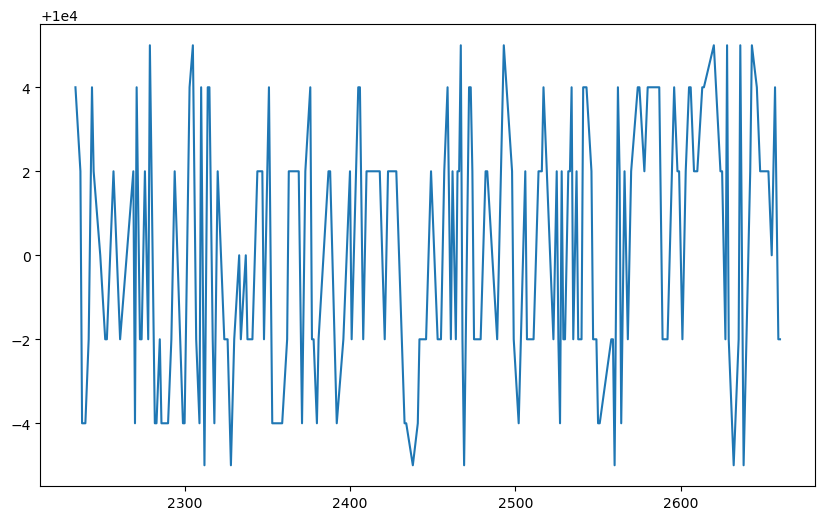

In [73]:
plt.figure(figsize=(10, 6))

trades_day0_A.price[1000:1200].plot()

In [51]:
trades_day0_A['diff'] = trades_day0_A.price.diff().replace(np.nan, 0)


/var/folders/nm/_864_8xs5yq4fs16m6wrq56h0000gn/T/ipykernel_2571/290178939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades_day0_A['diff'] = trades_day0_A.price.diff().replace(np.nan, 0)


In [59]:
from collections import defaultdict


In [58]:
trades_day0_A['price']

1       10002.0
2        9998.0
3        9998.0
6       10004.0
7       10002.0
         ...   
5306    10002.0
5307    10002.0
5309    10002.0
5313    10002.0
5314     9995.0
Name: price, Length: 2404, dtype: float64

In [60]:
def calculate_diff_probabilities(df):
    # Group by price and then calculate the probabilities of diff values
    price_diff_probs = defaultdict(dict)
    for price, group in df.groupby('price'):
        diff_counts = group['diff'].value_counts()
        for diff_val, count in diff_counts.items():
            price_diff_probs[price][diff_val] = count / diff_counts.sum()
    
    return price_diff_probs


In [63]:
diff_probabilities = calculate_diff_probabilities(trades_day0_A)
diff_probabilities

defaultdict(dict,
            {9995.0: {-3.0: 0.3233082706766917,
              -7.0: 0.2706766917293233,
              -1.0: 0.15037593984962405,
              -10.0: 0.09774436090225563,
              -9.0: 0.09022556390977443,
              0.0: 0.06766917293233082},
             9996.0: {0.0: 0.30945558739255014,
              -2.0: 0.25787965616045844,
              -6.0: 0.22636103151862463,
              -8.0: 0.08595988538681948,
              -9.0: 0.05730659025787966,
              1.0: 0.05157593123209169,
              -4.0: 0.011461318051575931},
             9998.0: {0.0: 0.36388508891928867,
              -4.0: 0.2503419972640219,
              2.0: 0.1409028727770178,
              -6.0: 0.12995896032831739,
              3.0: 0.060191518467852256,
              -7.0: 0.04377564979480164,
              -2.0: 0.01094391244870041},
             10000.0: {2.0: 0.3181818181818182,
              -2.0: 0.3181818181818182,
              -4.0: 0.2727272727272727,
              